In [3]:
import logging
logging.basicConfig(level="INFO")



In [4]:

from spyffi.Observation import Observation, default

inputs = default

In [5]:
print inputs['catalog']

{'skykw': {'faintlimit': None, 'fast': False}, 'catalogue': 'UCAC4', 'starsarevariable': True, 'name': 'sky', 'lckw': {'fractionwithextremelc': 0.005, 'fractionofstarswithlc': 0.5, 'fractionwithcustom': 0.1, 'fractionwithrotation': 0.2, 'seed': 0, 'fainteststarwithlc': None, 'options': ['trapezoid', 'sin'], 'fractionwithtrapezoid': 0.3}, 'testpatternkw': {'randomizenudgesby': 21.1, 'randomizepropermotionsby': 0.0, 'spacing': 500.0, 'magnitudes': [10, 10], 'randomizemagnitudes': False}}


In [6]:

inputs['camera']['label'] = 'transit'
inputs['catalog']['name'] = 'testpattern'
inputs['camera']['subarray'] = 50
inputs['camera']['variablefocus'] = False
inputs['expose']['jitterscale'] = 1.0
inputs['expose']['skipcosmics'] = True
inputs['catalog']['testpatternkw']['randomizemagnitudes'] = True
inputs['catalog']['testpatternkw']['magnitudes'] = [6,16]


inputs['observation']['cadencestodo'] = {120:216}
o = Observation(inputs)

INFO:spyffi.Observation:  creating a new observation, with the following inputs:
INFO:spyffi.Observation:      inputs[expose] = 
INFO:spyffi.Observation:                 magnitudethreshold:999
INFO:spyffi.Observation:                             jitter:True
INFO:spyffi.Observation:                     correctcosmics:True
INFO:spyffi.Observation:                              smear:False
INFO:spyffi.Observation:                   cosmicsdiffusion:True
INFO:spyffi.Observation:                           compress:{120: True, 1800: False, 2: True, 20: True}
INFO:spyffi.Observation:                     cosmicsversion:fancy
INFO:spyffi.Observation:                       writecosmics:False
INFO:spyffi.Observation:                     writesimulated:True
INFO:spyffi.Observation:                        skipcosmics:True
INFO:spyffi.Observation:                        jitterscale:1.0
INFO:spyffi.Observation:                     writenoiseless:False
INFO:spyffi.Observation:                          

In [7]:
import spyffi.Lightcurve as lc, numpy as np
for i in range(len(o.camera.catalog.ra)):
    o.camera.catalog.lightcurves[i] = lc.constant()

print o.camera.catalog.tmag
ra, dec = o.camera.catalog.ra, o.camera.catalog.dec
coord = o.camera.cartographer.point(ra, dec, 'celestial')
x, y = coord.ccdxy.tuple

n = o.camera.ccds[0].xsize
ok = (x > 0)*(x < n)*(y < n)*(y > 0)
ok *= (o.camera.catalog.tmag < 11.0)
lucky = np.random.choice(np.nonzero(ok)[0], 1)[0]
o.camera.catalog.lightcurves[lucky] = lc.Trapezoid(P=0.3, 
                                                   E=2457827.0 + 0.15, 
                                                   D=1.0, 
                                                   T23=0.00, 
                                                   T14=0.1)

[ 11.16790675  13.32467192  14.28569001  11.95697744  11.33991975   8.56472192   9.86503652  13.76058328   6.16054829   6.42289705   6.18010181   9.77671451   7.23171121   6.80631142   9.5889311   15.66661859]


In [8]:
print o.camera.catalog.lightcurves

[<constant()> <constant()> <constant()> <constant()> <constant()> <Trapezoid(T14=0.1,P=0.3,T23=0.0,E=2457827.15,D=1.0)> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()>]


<Trapezoid(T14=0.1,P=0.3,T23=0.0,E=2457827.15,D=1.0)>


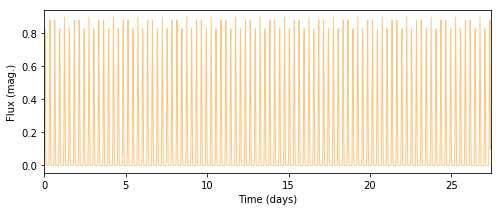

In [9]:
%matplotlib inline 
l = o.camera.catalog.lightcurves[lucky]
l.demo()
print l

INFO:spyffi.Camera:setting cadence to 120 seconds = 60 reads.
INFO:spyffi.Jitter:populating the jitterball for 120 second cadence, based on the raw jitter file cartoon.jitter.cadence120s.unscaled.
INFO:spyffi.PSF:initializing PSF painter, based on woods_prf_feb2016/RAYS_ptSrc_wSi_Oct27model_AP40.6_75C_F3p314adj
INFO:spyffi.Intrapixel:creating an intrapixel sensitivity map called perfectpixels
INFO:spyffi.PSF:setting up the pixel arrays
INFO:spyffi.PSF:created pixel coordinate arrays
INFO:spyffi.CCD:created CCD #1, of size 21x21
INFO:spyffi.PSF:trying to load PSFs from /Users/zkbt/.tess/spyffi/intermediates/psfs/RRUasbuilt/focus0and10_stellartemp4350/pixelizedlibrary_cartoon.jitter.cadence120s.unscaled_perfectpixels_11positions_11offsets.npy
INFO:spyffi.PSF:...success!
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.Catalogs:save projected star catalog /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/catalog_testpattern_sub50x50_

INFO:spyffi.CCD:created image #0000002 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.154655106366,0.364365013136 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.00417 = 2017.20055898
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        

INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 7 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000007.fits
INFO:spyffi.CCD:created image #0000007 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.0876222560875,-0.225097879189 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.01111 = 2017.20057799
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aber

INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.02; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 12 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000012.fits
INFO:spyffi.CCD:created image #0000012 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudge

INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.02; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 17 for sub50x50
INFO:

INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated expos

INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.0375 = 2017.20065024
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_tran

INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to -0.104420621236,0.10276201087 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.04444 = 2017.20066925
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.01; flux change over entire image is 0.

INFO:spyffi.CCD:saving simulated exposure 36 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000036.fits
INFO:spyffi.CCD:created image #0000036 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.0483937343247,0.459838107268 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.05139 = 2017.20068827
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image 

INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 41 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000041.fits
INFO:spyffi.CCD:created image #0000041 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.01404018143,0.163137346376 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.05833 = 2017.20070728
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberra

INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.02; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 46 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_tran

INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 51 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_

INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.07778 = 2017.20076051
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_tra

INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 60 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000060.fits
INFO:spyffi.CCD:created image #0000060 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.105780969899,-0.0927762091621 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.08472 = 2017.20077953
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons fro

INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 65 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000065.fits
INFO:spyffi.CCD:created image #0000065 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.154899547595,-0.205882620662 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.09167 = 2017.20079854
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:addi

INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 70 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000070.fits
INFO:spyffi.CCD:created image #0000070 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to -0.00386795970543,0.234613592425 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.09861 = 2017.20081755
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity ab

INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is -0.00 electrons
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 75 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000075.fits
INFO:spyffi.CCD:created image #0000075 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.105084299676,-0.144550387734 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 245782

INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.02; flux change over entire image is -0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.C

INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.11806 = 2017.20087079
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.01; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux chan

INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 89 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000089.fits
INFO:spyffi.CCD:created image #0000089 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.0567210897633,0.113297522695 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.125 = 2017.2008898
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from st

INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 94 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000094.fits
INFO:spyffi.CCD:created image #0000094 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.0916250883962,0.0822193960049 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.13194 = 2017.20090881
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9

INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 99 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000099.fits
INFO:spyffi.CCD:created image #0000099 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0

INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.01; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is -0.00 electrons
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 104 for sub50x50
INF

INFO:spyffi.CCD:created image #0000108 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to -0.0812570090027,0.0102874637526 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.15139 = 2017.20096205
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:     

INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000113.fits
INFO:spyffi.CCD:created image #0000113 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.0836665229243,-0.365290306716 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.15833 = 2017.20098106
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/

INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 118 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000118.fits
INFO:spyffi.CCD:created image #0000118 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to -0.088598111214,-0.307972448051 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.16528 = 2017.20100008
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity ab

INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 123 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000123.fits
INFO:spyffi.CCD:created image #0000123 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.12480807942,-0.0767781892388 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 245782

INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.01; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CC

INFO:spyffi.CCD:created image #0000132 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.00249495546431,-0.166323340937 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.18472 = 2017.20105331
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:     

INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000137.fits
INFO:spyffi.CCD:created image #0000137 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to -0.0101660552934,0.0238777931697 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.19167 = 2017.20107232
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess

INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 142 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000142.fits
INFO:spyffi.CCD:created image #0000142 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.435311531171,0.131558235037 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.19861 = 2017.20109134
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aber

INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 147 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_tra

INFO:spyffi.CCD:created image #0000151 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.128167929025,0.0608914724088 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.21111 = 2017.20112556
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:       

INFO:spyffi.CCD:created image #0000156 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.0395376063266,-0.252486221703 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.21806 = 2017.20114457
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:      

INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 161 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000161.fits
INFO:spyffi.CCD:created image #0000161 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to -0.303761322535,-0.0627624017188 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.225 = 2017.20116359
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity abe

INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.01; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CC

INFO:spyffi.CCD:created image #0000170 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to -0.0573076053274,0.181847368978 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.2375 = 2017.20119781
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:       

INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 175 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000175.fits
INFO:spyffi.CCD:created image #0000175 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to -0.301381018281,-0.0275069605745 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.24444 = 2017.20121682
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity a

INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 180 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000180.fits
INFO:spyffi.CCD:created image #0000180 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to -0.0658414569195,-0.0929579464078 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 245

INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 185 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_tra

INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.26389 = 2017.20127006
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.01; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux chan

INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 194 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000194.fits
INFO:spyffi.CCD:created image #0000194 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to -0.0346228726185,0.121008192158 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.27083 = 2017.20128907
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons fr

INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.02; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is -0.00 electrons
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 199 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000199.fits
INFO:spyffi.CCD:created image #0000199 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nud

INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 204 for sub50x50
INFO:spyffi.CCD:saving 50x50 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000204.fits
INFO:spyffi.CCD:created image #0000204 of testpattern with 120s cadence
INFO:spyffi.Jitter:updat

INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.29028 = 2017.20134231
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/photonnoise.fits
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.02; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux chan

INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/simulated_testpattern_6to16_sub50x50_000213.fits
INFO:spyffi.CCD:created image #0000213 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to -0.176317745514,0.269403192241 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.29722 = 2017.20136132
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 4 stars between 6.2 and 9.9 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 50x50 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub50x50/

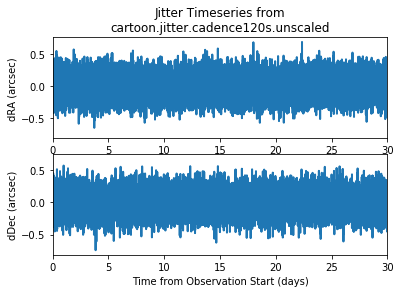

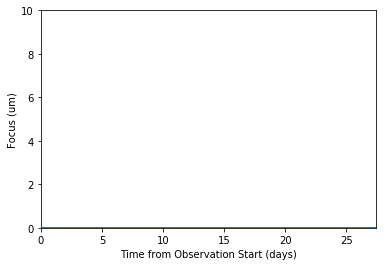

In [10]:
o.create()

In [2]:
# !ds9 /Users/zkbt/.tess/spyffi/outputs/testpattern_6to16_transit/120s/sub100x100/simulated_testpattern_6to16_sub100x100_0000*